In [1]:
%run notebook.config.ipy


Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust




Attaching package: ‘reshape2’

The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast




Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



Loading required package: DBI


set database db: ../csvdb
set database anndb: /gfs/mirror/annotations/mm10_ensembl78/csvdb
set database ipydb: csvdb


In [2]:
statement = '''select * from qc_summary'''

qc_summary = DB.fetch_DataFrame(statement,db)

qc_summary.head()

,cell,fraction_spike,fraction_spliced,no_genes,pct_pf_reads,pct_pf_reads_aligned,pct_reads_aligned_in_pairs,percent_coding,percent_mrna,percent_reads_aligned,three_prime_bias,total_reads,uniq_mapping_reads_genome,uniq_mapping_reads_spike
0,Scid_recons_p2_A1,0.133414,0.299559,4939,1,0.733578,0,0.411572,0.693869,0.733578,0.92,634373,59242,384804
1,Scid_recons_p2_A10,0.772061,0.063011,1153,1,0.679931,0,0.064654,0.124000,0.679931,1.00,2713587,1351190,398918
2,Scid_recons_p2_A11,0.399202,0.110180,3649,1,0.632537,0,0.126357,0.402014,0.632537,1.76,3042591,738670,1111696
3,Scid_recons_p2_A12,0.152076,0.255641,5543,1,0.699209,0,0.328629,0.642612,0.699209,1.04,3447660,344852,1922781
4,Scid_recons_p2_A2,0.155280,0.296962,5168,1,0.734051,0,0.389387,0.674383,0.734051,0.92,1379193,144816,787794


In [3]:
df = qc_summary.loc[:,['cell','fraction_spike','no_genes']]
df.head()

,cell,fraction_spike,no_genes
0,Scid_recons_p2_A1,0.133414,4939
1,Scid_recons_p2_A10,0.772061,1153
2,Scid_recons_p2_A11,0.399202,3649
3,Scid_recons_p2_A12,0.152076,5543
4,Scid_recons_p2_A2,0.155280,5168


In [4]:
%%R -i df
df$plate = sapply(strsplit(as.character(df$cell), "_"), function(x){return(x[3])})
df$well = sapply(strsplit(as.character(df$cell), "_"), function(x){return(x[4])})
df$col = substring(df$well,1,1)
df$row = substring(df$well, 2)
print(str(df))

'data.frame':	96 obs. of  7 variables:
 $ cell          : Factor w/ 96 levels "Scid_recons_p2_A1",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ fraction_spike: num [1:96(1d)] 0.133 0.772 0.399 0.152 0.155 ...
 $ no_genes      : int [1:96(1d)] 4939 1153 3649 5543 5168 7671 4390 4661 4410 4413 ...
 $ plate         : chr  "p2" "p2" "p2" "p2" ...
 $ well          : chr  "A1" "A10" "A11" "A12" ...
 $ col           : chr  "A" "A" "A" "A" ...
 $ row           : chr  "1" "10" "11" "12" ...
NULL


Using cell, plate, well, col, row as id variables
                cell plate well col row       variable     value
1  Scid_recons_p2_A1    p2   A1   A   1 fraction_spike 0.1334140
2 Scid_recons_p2_A10    p2  A10   A  10 fraction_spike 0.7720610
3 Scid_recons_p2_A11    p2  A11   A  11 fraction_spike 0.3992020
4 Scid_recons_p2_A12    p2  A12   A  12 fraction_spike 0.1520760
5  Scid_recons_p2_A2    p2   A2   A   2 fraction_spike 0.1552800
6  Scid_recons_p2_A3    p2   A3   A   3 fraction_spike 0.0576068
Saving 9.72 x 8.33 in image


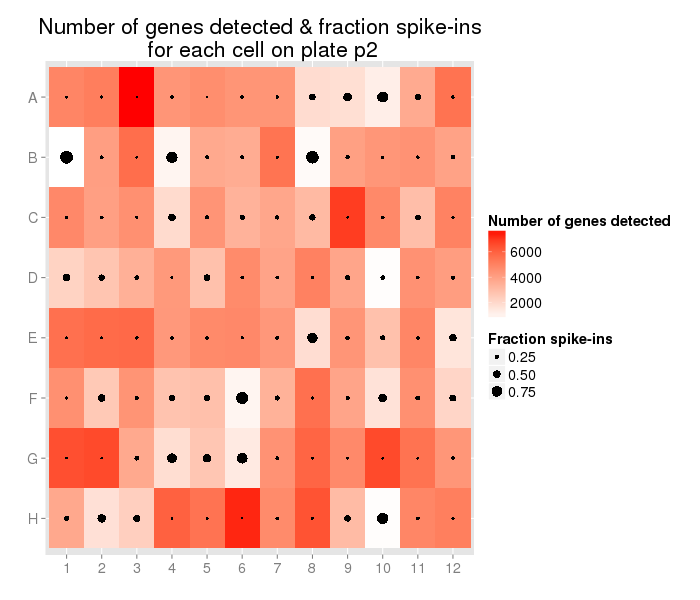

In [9]:
%%R -w 700 -h 600
melted = melt(df)
print(head(melted))
melted = melted[order(as.numeric(melted$row)),]
melted$row = factor(melted$row, levels=(melted$row))
melted$col = factor(melted$col, levels=rev(melted$col))


for (p in unique(df$plate)){
gp <- ggplot(melted) + geom_tile(data= melted[melted$variable == "no_genes",], aes(x=row, y=col, fill = value))
gp <- gp + scale_fill_gradient(low="white", high = "red", na.value="grey", name="Number of genes detected") 
gp <- gp + geom_point(data=melted[melted$variable == "fraction_spike",],aes(x=row, y=col, size=value))
gp <- gp + labs(size = 'Fraction spike-ins')
gp <- gp + ggtitle(paste("Number of genes detected & fraction spike-ins\n for each cell on plate ", p, sep=""))
gp <- gp + xlab("")+ ylab("")
print(gp)
ggsave(plot = gp, filename=paste("number_genes_fraction_spike_plate_", p,".pdf", sep=""), device=cairo_pdf)
}